In [1]:
from sklearn.decomposition import PCA
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [3]:
def rename_column_name(data,collapse_type):
    for feature in filter(lambda feature: ("x" in feature) 
                          or ("y" in feature) or ("z" in feature) 
                          or ("AA" in feature), data.columns): 
        data  = data.rename({feature: "{}_{}"\
                            .format(collapse_type, feature)}, axis = 1)
    return data

In [9]:
entityV1 = syn.get("syn21046180")
dataV1   = pd.read_csv(entityV1["path"], index_col = 0)
dataV1 = dataV1.drop(["healthCode", "phoneInfo", "createdOn"], axis = 1)
dataV1 = dataV1.reset_index(drop = True)
dataV1["version"] = "V1"

In [10]:
entityV2 = syn.get("syn21046181")
dataV2   = pd.read_csv(entityV2["path"], index_col = 0)
dataV2 = dataV2.drop(["healthCode", "phoneInfo", "createdOn"], axis = 1)
dataV2 = dataV2.reset_index(drop = True)
dataV2["version"] = "V2"

In [11]:
entityPassive = syn.get("syn21046184")
dataPassive   = pd.read_csv(entityPassive["path"], index_col = 0)
dataPassive = dataPassive.drop(["healthCode", "phoneInfo", "createdOn"], axis = 1)
dataPassive = dataPassive.reset_index(drop = True)
dataPassive["version"] = "Passive"

In [12]:
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)

# PCA

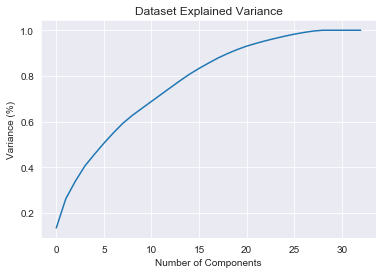

In [16]:
scaler = StandardScaler()
X = data.drop(["version", "PD", "gender", "recordId"], axis = 1)
y = data[["version", "PD"]]
X_scaled = scaler.fit_transform(X)
#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.grid()
plt.show()

In [20]:
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 30)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_comp)
principal_df = pd.concat([principal_df, y], axis = 1)

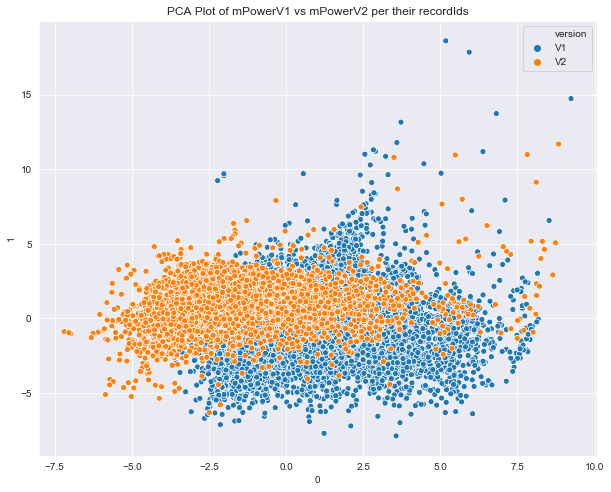

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df["version"])
plt.title("PCA Plot of mPowerV1 vs mPowerV2 per their recordIds")
plt.grid()
plt.show()

# PCA healthCodes

In [12]:
grouped_df_v1 = pd.read_csv("../Data/MAX_WALKING_TRAINING_DATA.csv").drop(["healthCode"], axis = 1)
grouped_df_v2 = pd.read_csv("../Data/MAX_WALKING_TRAINING_DATA_V2.csv").drop(["healthCode"], axis = 1)
grouped_df_passive = pd.read_csv("../Data/MAX_WALKING_TRAINING_DATA_PASSIVE.csv").drop(["healthCode"], axis = 1)
grouped_df_v1["version"] = "V1"
grouped_df_v2["version"] = "V2"
grouped_df_passive["version"] = "Passive"
grouped_data = pd.concat([grouped_df_v1, grouped_df_v2, grouped_df_passive]).reset_index(drop = True)

In [13]:
scaler = StandardScaler()
X = grouped_data.drop(["version", "PD"], axis = 1)
y = grouped_data[["version", "PD"]]
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_comp)
principal_df = pd.concat([principal_df, y], axis = 1)

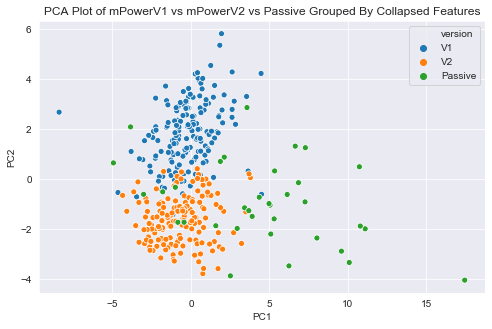

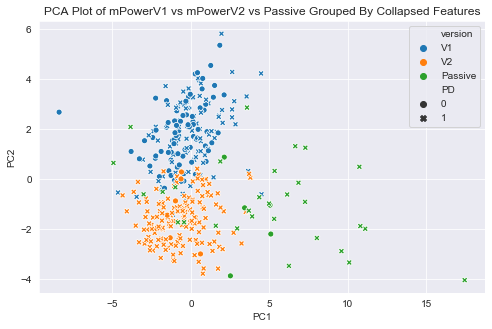

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df["version"])
plt.title("PCA Plot of mPowerV1 vs mPowerV2 vs Passive Grouped By Collapsed Features")
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.grid()
plt.show()


plt.figure(figsize=(8,5))
sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df["version"], style = principal_df["PD"])
plt.title("PCA Plot of mPowerV1 vs mPowerV2 vs Passive Grouped By Collapsed Features")
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.grid()
plt.show()

# Is the feature values in V2 biased?
Looking from the values in the Principal Component Plot, we can see that there are some cluster between the versions the mPower data, now we will compare by stratifying those who has parkinson, we will see if each features are actually different across the versions. An dependent t-test will be hold to compare the two means. 

In [170]:
def plot_distribution(data):
    for i in [i for i in data.columns if ("x" in i) or ("y" in i) or ("z" in i) or ("AA" in i)]:
        V1 = data[data["version"] == "V1"][i].dropna()
        V2 = data[data["version"] == "V2"][i].dropna()
#         Passive = data[data["version"] == "Passive"][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(V1, label = "V1", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(V2, label = "V2", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(Passive, label = "Passive", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "version", y = i, data = data, ax = axes[1], orient = "v")
        axes[0].set_title("p-values: {}".format(ttest_ind(V1, V2)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()

In [171]:
PD_grouped = grouped_data[grouped_data["PD"] == 1]

In [172]:
PD_grouped

,max_x.no_of_steps,max_x.gait_step_regularity,max_x.gait_stride_regularity,max_x.gait_symmetry,max_x.frequency_of_peaks,max_x.max_freeze_index,max_x.freeze_occurences,max_x.speed_of_gait,max_y.no_of_steps,max_y.gait_step_regularity,...,max_AA.no_of_steps,max_AA.gait_step_regularity,max_AA.gait_stride_regularity,max_AA.gait_symmetry,max_AA.frequency_of_peaks,max_AA.max_freeze_index,max_AA.freeze_occurences,max_AA.speed_of_gait,PD,version
0,21.0,0.970228,1.0,0.171369,3.084409e+03,68.855484,39.0,0.594427,20.0,0.957758,...,11.0,1.0,1.0,0.248645,97816.459501,35.256336,30.0,0.531395,1,V1
7,26.0,1.000000,1.0,0.181596,6.757768e+04,52.111069,25.0,0.408861,23.0,1.000000,...,21.0,1.0,1.0,0.200407,3547.608437,12.261449,21.0,0.311144,1,V1
9,25.0,1.000000,1.0,0.109256,2.395279e+03,21.961264,44.0,0.134518,18.0,1.000000,...,15.0,1.0,1.0,0.289806,6078.673506,2.779339,4.0,0.196961,1,V1
10,30.0,1.000000,1.0,0.221617,2.875921e+04,141.451645,55.0,0.186447,30.0,1.000000,...,13.0,1.0,1.0,0.175391,5194.956586,6.177542,11.0,0.237680,1,V1
13,27.0,1.000000,1.0,0.317302,1.677722e+07,28.548513,46.0,0.209108,30.0,1.000000,...,27.0,1.0,1.0,0.318767,46192.560475,12.532166,26.0,0.249379,1,V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,58.0,1.000000,1.0,0.304280,1.005627e+05,7397.779297,55.0,0.441486,61.0,1.000000,...,50.0,1.0,1.0,0.296808,617590.188232,204.490936,55.0,0.351846,1,Passive
360,27.0,1.000000,1.0,0.066771,1.199875e+03,24.660767,44.0,0.273303,35.0,1.000000,...,20.0,1.0,1.0,0.141370,1608.054839,2.206186,1.0,0.371205,1,Passive
361,54.0,1.000000,1.0,0.295491,1.439689e+04,83.785187,55.0,0.363830,55.0,1.000000,...,34.0,1.0,1.0,0.268994,269540.606008,24.609310,43.0,0.418623,1,Passive
362,53.0,1.000000,1.0,0.273530,2.945618e+06,128.659683,55.0,0.404913,55.0,1.000000,...,29.0,1.0,1.0,0.326751,35374.325876,27.272717,7.0,0.391853,1,Passive


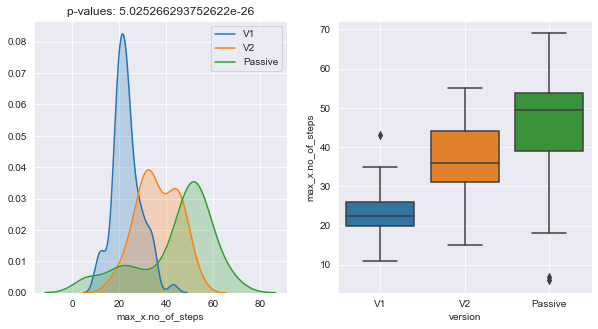

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



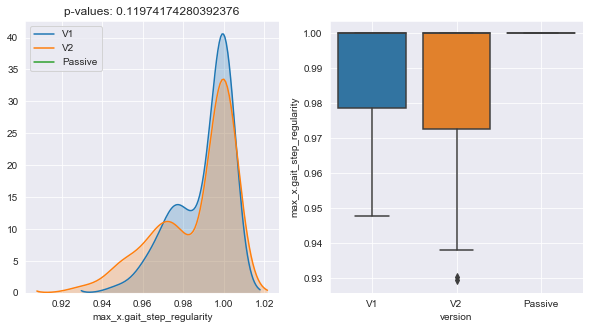

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



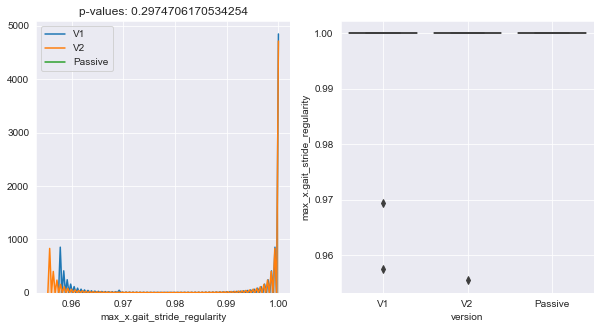

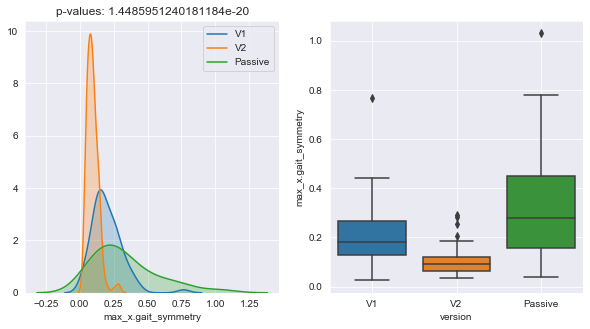

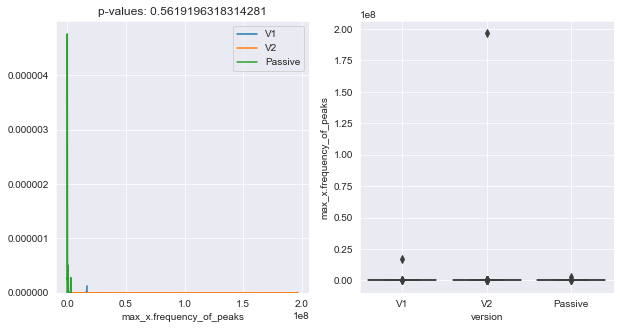

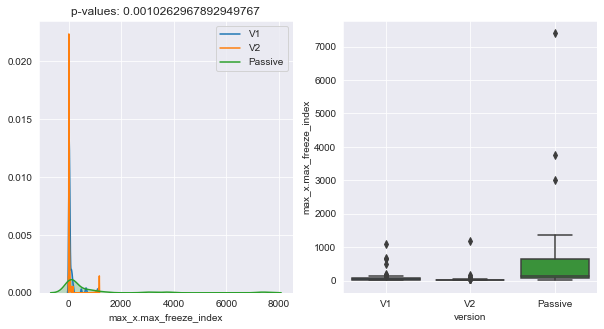

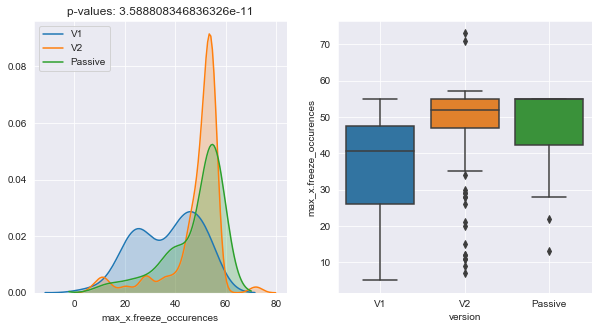

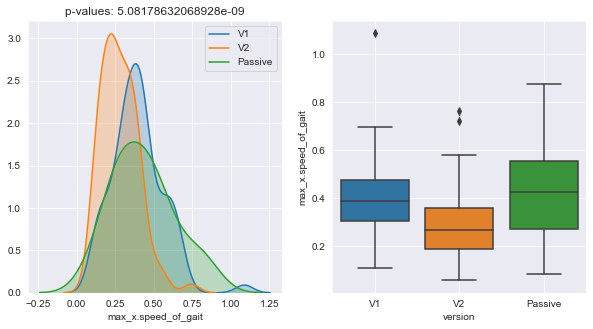

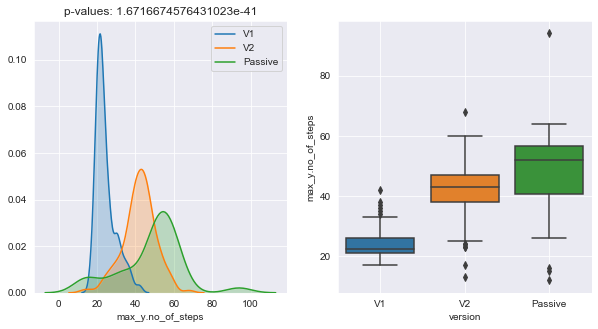

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



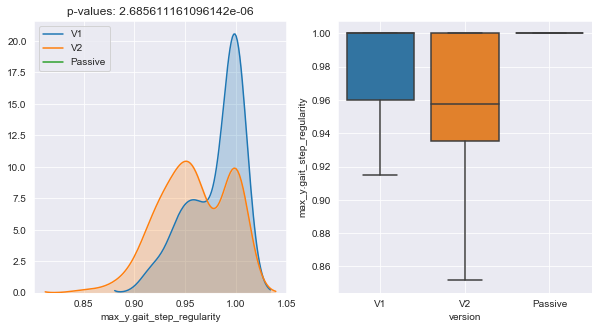

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



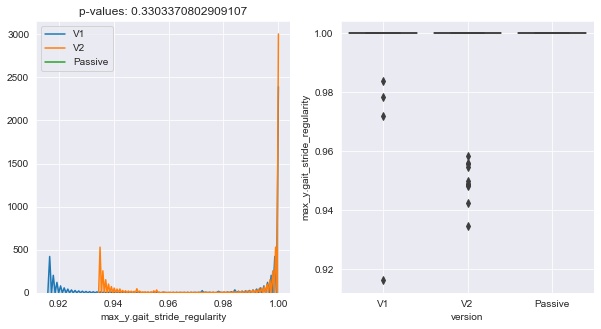

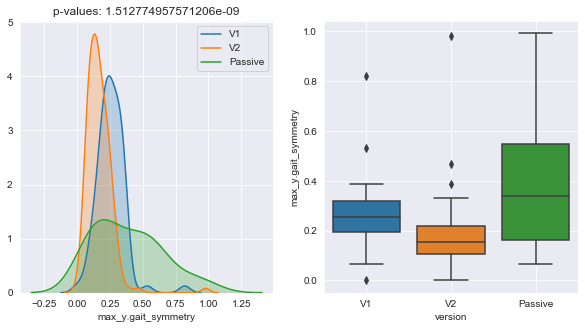

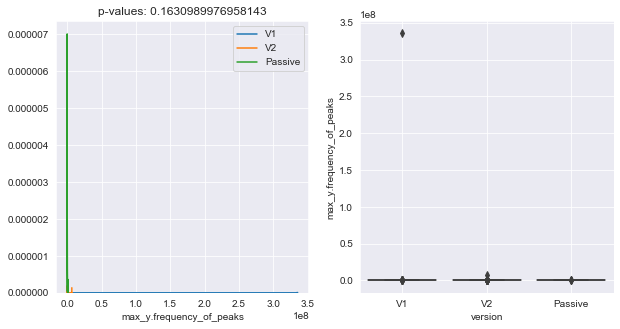

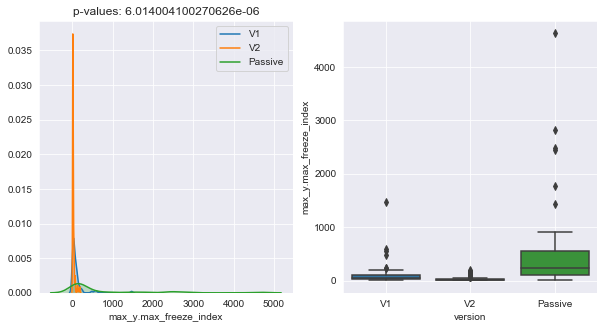

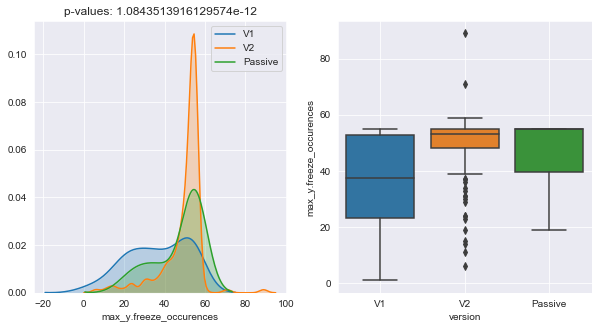

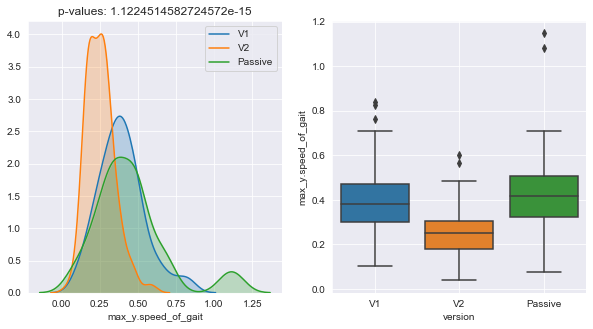

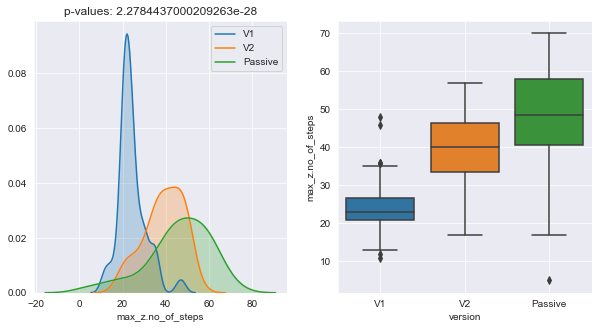

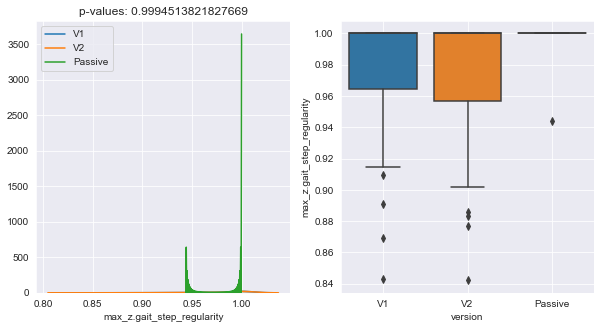

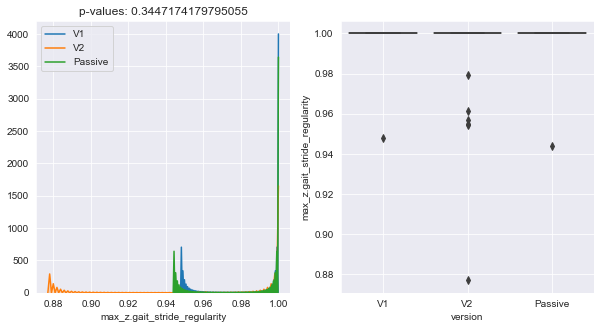

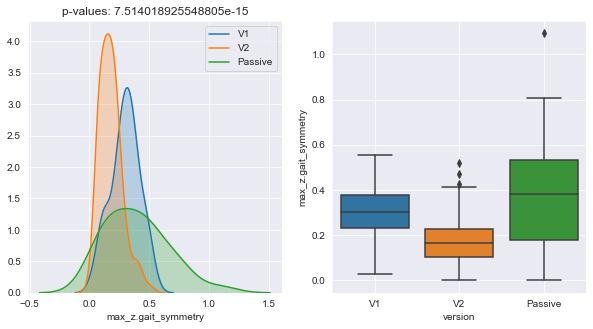

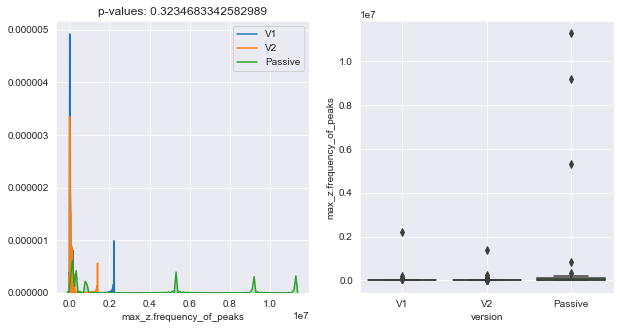

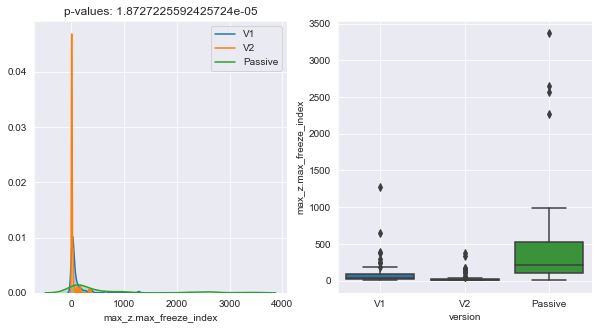

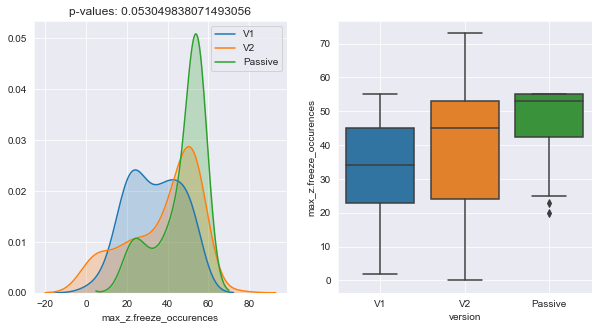

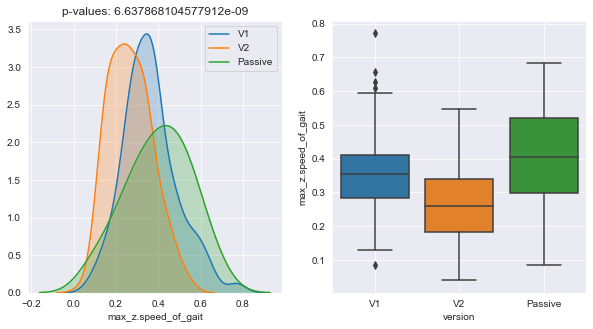

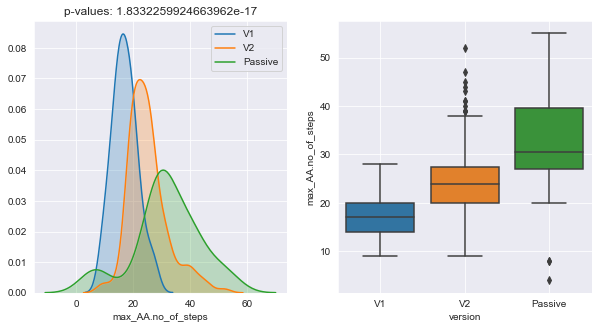

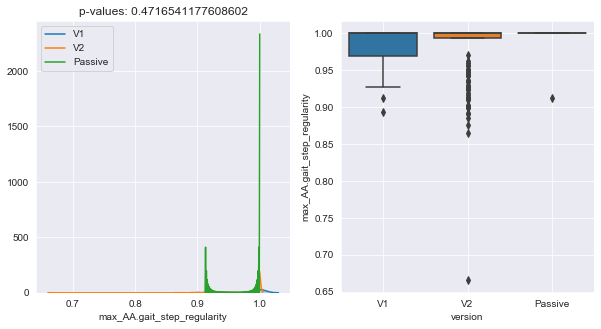

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



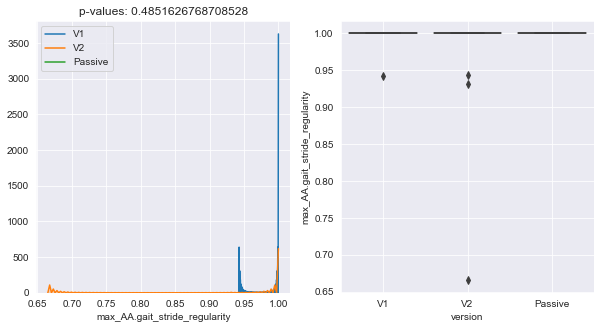

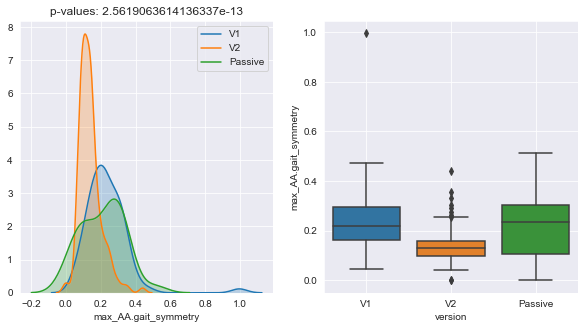

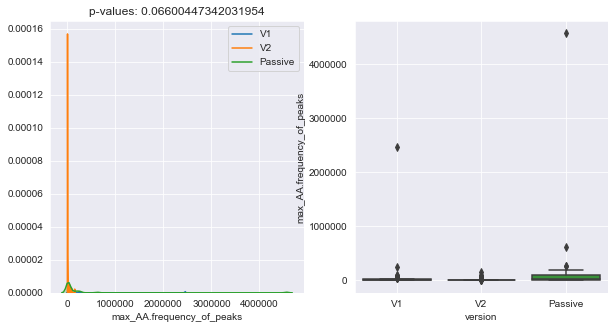

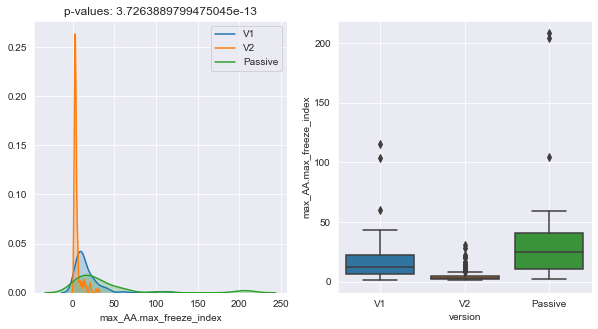

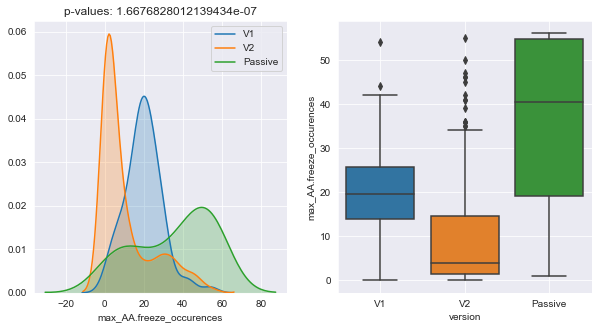

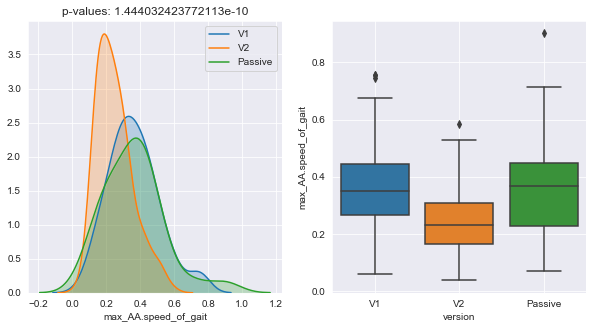

In [173]:
plot_distribution(PD_grouped)

# T-Sne

In [126]:
X_embedded = TSNE(n_components=2).fit_transform(X_scaled)

In [127]:
tSNE_df = pd.DataFrame(data = X_embedded)
tSNE_df = pd.concat([tSNE_df, data[["version", "PD"]]], axis = 1)

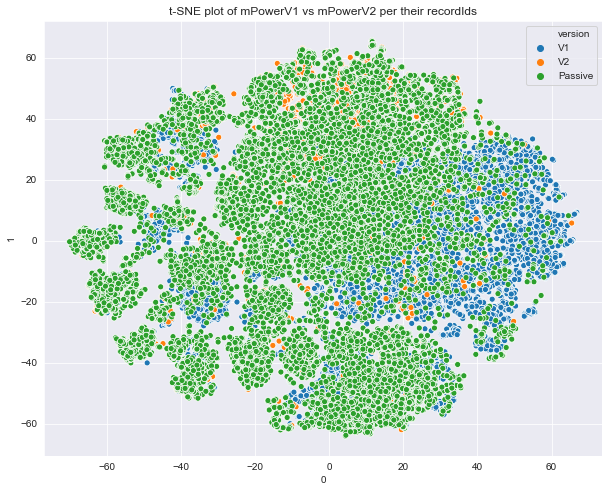

In [128]:
plt.figure(figsize=(10,8))
sns.scatterplot(tSNE_df[0], tSNE_df[1], hue = tSNE_df["version"])
plt.title("t-SNE plot of mPowerV1 vs mPowerV2 per their recordIds")
plt.grid()
plt.show()